# This code should be run on colab or jupyter notebook

## 1. Import library and set up path

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle/Weather"
%cd /content/drive/MyDrive/Kaggle/Weather

Mounted at /content/drive
/content/drive/MyDrive/Kaggle/Weather


In [ ]:
!pip install meteostat

## 2. Get data from meteostat
The information can be found at: https://meteostat.net/en/place/vn/di-an?s=48900&t=2023-01-01/2023-11-28

In [ ]:
from meteostat import Stations
stations = Stations()
stations = stations.region('VN','CM')
# Print DataFrame
print(stations.count())

1


In [ ]:
from datetime import datetime
from meteostat import Hourly

start = datetime(2022, 1, 1)
end = datetime(2023, 11, 28, 23, 59)

data = Hourly('48900', start, end)
data = data.fetch()

data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2022-01-01 00:00:00,24.0,18.0,69.0,NaN,NaN,40.0,7.6,NaN,1014.0,NaN,2.0
2022-01-01 01:00:00,26.0,17.9,61.0,NaN,NaN,60.0,7.6,NaN,1014.0,NaN,2.0
2022-01-01 02:00:00,28.0,16.9,51.0,NaN,NaN,70.0,9.4,NaN,1015.0,NaN,2.0
2022-01-01 03:00:00,29.0,16.9,48.0,NaN,NaN,54.0,3.6,NaN,1014.0,NaN,2.0
2022-01-01 04:00:00,31.0,17.0,43.0,NaN,NaN,44.0,5.4,NaN,1014.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-28 19:00:00,26.0,23.1,84.0,0.0,NaN,50.0,9.0,NaN,1009.0,NaN,3.0
2023-11-28 20:00:00,25.0,22.1,84.0,0.0,NaN,50.0,9.0,NaN,1008.0,NaN,3.0
2023-11-28 21:00:00,25.0,22.1,84.0,0.0,NaN,40.0,9.0,NaN,1008.0,NaN,3.0


## 3. Preprocessing data

In [ ]:
data.to_csv('weather.csv', sep=',', index=False)

In [ ]:
humidf = data['rhum']
tempdf = data['temp']

In [ ]:
humidf

time
2022-01-01 00:00:00    69.0
2022-01-01 01:00:00    61.0
2022-01-01 02:00:00    51.0
2022-01-01 03:00:00    48.0
2022-01-01 04:00:00    43.0
                       ... 
2023-11-28 19:00:00    84.0
2023-11-28 20:00:00    84.0
2023-11-28 21:00:00    84.0
2023-11-28 22:00:00    84.0
2023-11-28 23:00:00    89.0
Name: rhum, Length: 16728, dtype: float64

In [ ]:
humidf.isnull().sum()

0

In [ ]:
humidf.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 16728 entries, 2022-01-01 00:00:00 to 2023-11-28 23:00:00
Series name: rhum
Non-Null Count  Dtype  
--------------  -----  
16728 non-null  float64
dtypes: float64(1)
memory usage: 261.4 KB


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler

In [ ]:
for i in [humidf,tempdf]:
  store = go.Scatter(
      x = i.index,
      y = i.values,
      mode = 'lines+markers',
      name = 'Store 1 Grocery sales'
  )
  layout = go.Layout (title=f'{i.name} chart', xaxis_title='Date', yaxis_title='Sale')

  fig = go.Figure(data=[store], layout =layout)
  fig.show()

In [ ]:
def split_series(series, past_num, future_num):
  X = []
  y = []
  i=0
  for w in range(len(series)):
    past_end = w + past_num
    future_end = past_end + future_num
    if future_end > len(series): break
    p, f = series[w:past_end,:], series[past_end:future_end,:]
    X.append(p)
    y.append(f)
  return np.array(X), np.array(y)

past_num = 24
future_num = 24
n_feature = 1

In [ ]:
def splitData(bb_df):
  test_split = bb_df.index[-(past_num+future_num)]
  train_split = bb_df.index[int(0.7*len(bb_df))]

  train_df = bb_df.loc[bb_df.index < train_split]
  test_df = bb_df.loc[(bb_df.index >= train_split) &(bb_df.index < test_split)]
  use_df = bb_df.loc[bb_df.index >= test_split]
  return train_df, test_df, use_df
train_humi, test_humi, use_humi = splitData(humidf)
train_temp, test_temp, use_temp = splitData(tempdf)


In [ ]:
scaler = MinMaxScaler()
def scaleData(train_df, test_df, use_df):
  new_train = np.array(train_df).reshape(-1,1)
  new_test = np.array(test_df).reshape(-1,1)
  new_use = np.array(use_df).reshape(-1,1)
  scaled_train = scaler.fit_transform(new_train)
  scaled_test = scaler.transform(new_test)
  scaled_use = scaler.transform(new_use)
  return scaled_train, scaled_test, scaled_use

scaled_train_humi, scaled_test_humi, scaled_use_humi = scaleData(train_humi, test_humi, use_humi)
scaled_train_temp, scaled_test_temp, scaled_use_temp = scaleData(train_temp, test_temp, use_temp)

## 4. Split data to train, test and evaluation

In [ ]:
def prepare_train(scaled_train,scaled_test,scaled_use):
  X_train, y_train = split_series(scaled_train,past_num, future_num)
  X_val, y_val = split_series(scaled_test,past_num, future_num)
  X_use, y_use = split_series(scaled_use[-2*past_num:,:],past_num, future_num)
  return X_train,y_train,X_val,y_val,X_use,y_use
X_train_humi,y_train_humi,X_val_humi,y_val_humi,X_use_humi,y_use_humi = prepare_train(scaled_train_humi, scaled_test_humi, scaled_use_humi )
X_train_temp,y_train_temp,X_val_temp,y_val_temp,X_use_temp,y_use_temp = prepare_train(scaled_train_temp, scaled_test_temp, scaled_use_temp)

## 5.1. Model for Huminity

In [ ]:
# RNN
import keras
from keras import layers
input = layers.Input(shape=(past_num,n_feature))
model = keras.Sequential()
model.add(input)
model.add(layers.SimpleRNN(units=256, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.SimpleRNN(units=256,return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(n_feature)))

model.compile(loss='mae', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics =['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 256)           66048     
                                                                 
 batch_normalization (Batch  (None, 24, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 256)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 256)           131328    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 24, 256)           0

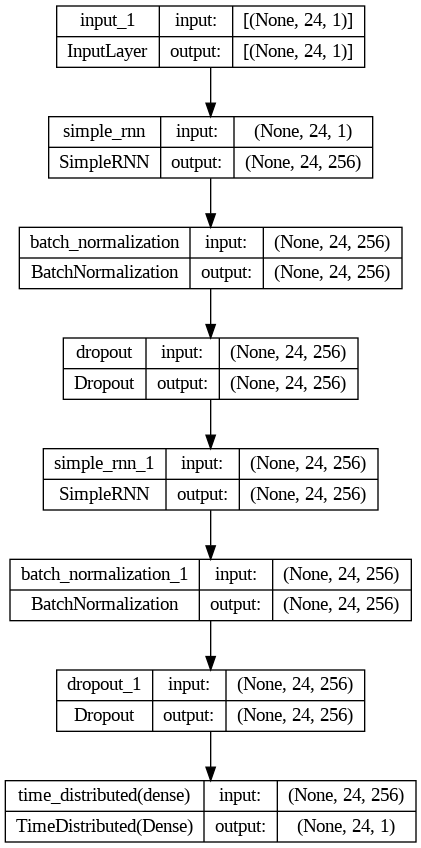

In [ ]:
keras.utils.plot_model(model, show_shapes = True, rankdir='TB')

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_mae', min_delta=0.0001, patience=100,restore_best_weights=True)
model_log = model.fit(X_train_humi,y_train_humi,validation_data=(X_val_humi, y_val_humi), epochs=1000,callbacks=[early_stop],batch_size =512)

Epoch 1/1000
23/23 [==============================] - 16s 91ms/step - loss: 1.0292 - mae: 1.0292 - val_loss: 0.3383 - val_mae: 0.3383
Epoch 2/1000
23/23 [==============================] - 1s 54ms/step - loss: 0.6044 - mae: 0.6044 - val_loss: 0.2118 - val_mae: 0.2118
Epoch 3/1000
23/23 [==============================] - 1s 47ms/step - loss: 0.5299 - mae: 0.5299 - val_loss: 0.2227 - val_mae: 0.2227
Epoch 4/1000
23/23 [==============================] - 2s 78ms/step - loss: 0.4741 - mae: 0.4741 - val_loss: 0.1907 - val_mae: 0.1907
Epoch 5/1000
23/23 [==============================] - 2s 88ms/step - loss: 0.4232 - mae: 0.4232 - val_loss: 0.1898 - val_mae: 0.1898
Epoch 6/1000
23/23 [==============================] - 2s 95ms/step - loss: 0.3762 - mae: 0.3762 - val_loss: 0.1792 - val_mae: 0.1792
Epoch 7/1000
23/23 [==============================] - 2s 71ms/step - loss: 0.3347 - mae: 0.3347 - val_loss: 0.1646 - val_mae: 0.1646
Epoch 8/1000
23/23 [==============================] - 1s 52ms/step -

In [ ]:
from keras.models import load_model
model.save('humireal.h5')
loaded_model_humi = load_model('humireal.h5')
loaded_model_humi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 256)           66048     
                                                                 
 batch_normalization (Batch  (None, 24, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 256)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 256)           131328    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 24, 256)           0

## 5.2. Model temparature

In [ ]:
input = layers.Input(shape=(past_num,n_feature))
model1 = keras.Sequential()
model1.add(input)
model1.add(layers.SimpleRNN(units=256, return_sequences=True))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.2))
model1.add(layers.SimpleRNN(units=256,return_sequences=True))
model1.add(layers.BatchNormalization())
model1.add(layers.Dropout(0.2))
model1.add(layers.TimeDistributed(layers.Dense(n_feature)))

model1.compile(loss='mae', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics =['mae'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 24, 256)           66048     
                                                                 
 batch_normalization_2 (Bat  (None, 24, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 24, 256)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 24, 256)           131328    
                                                                 
 batch_normalization_3 (Bat  (None, 24, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 24, 256)          

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_mae', min_delta=0.0001, patience=100,restore_best_weights=True)
model_log = model1.fit(X_train_temp,y_train_temp,validation_data=(X_val_temp, y_val_temp), epochs=1000,callbacks=[early_stop],batch_size =512)

Epoch 1/1000
23/23 [==============================] - 6s 116ms/step - loss: 0.8541 - mae: 0.8541 - val_loss: 0.2664 - val_mae: 0.2664
Epoch 2/1000
23/23 [==============================] - 2s 93ms/step - loss: 0.5365 - mae: 0.5365 - val_loss: 0.1596 - val_mae: 0.1596
Epoch 3/1000
23/23 [==============================] - 1s 54ms/step - loss: 0.4619 - mae: 0.4619 - val_loss: 0.1329 - val_mae: 0.1329
Epoch 4/1000
23/23 [==============================] - 1s 52ms/step - loss: 0.4056 - mae: 0.4056 - val_loss: 0.1290 - val_mae: 0.1290
Epoch 5/1000
23/23 [==============================] - 1s 48ms/step - loss: 0.3550 - mae: 0.3550 - val_loss: 0.1315 - val_mae: 0.1315
Epoch 6/1000
23/23 [==============================] - 1s 47ms/step - loss: 0.3080 - mae: 0.3080 - val_loss: 0.1256 - val_mae: 0.1256
Epoch 7/1000
23/23 [==============================] - 1s 45ms/step - loss: 0.2661 - mae: 0.2661 - val_loss: 0.1286 - val_mae: 0.1286
Epoch 8/1000
23/23 [==============================] - 1s 51ms/step -

In [ ]:
from keras.models import load_model
model1.save('tempreal.h5')
loaded_model_temp = load_model('tempreal.h5')
loaded_model_temp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 24, 256)           66048     
                                                                 
 batch_normalization_2 (Bat  (None, 24, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 24, 256)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 24, 256)           131328    
                                                                 
 batch_normalization_3 (Bat  (None, 24, 256)           1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 24, 256)          

## 6. Evaluation and predict

### 6.1. Huminity

In [ ]:
print(X_use_humi)
X_use_humi.shape

[[[0.84722222]
  [0.70833333]
  [0.76388889]
  [0.52777778]
  [0.52777778]
  [0.61111111]
  [0.29166667]
  [0.22222222]
  [0.25      ]
  [0.29166667]
  [0.43055556]
  [0.47222222]
  [0.47222222]
  [0.52777778]
  [0.47222222]
  [0.52777778]
  [0.52777778]
  [0.58333333]
  [0.63888889]
  [0.63888889]
  [0.63888889]
  [0.76388889]
  [0.76388889]
  [0.76388889]]]


(1, 24, 1)

In [ ]:
y_use_humi_reverse = pd.DataFrame(scaler.inverse_transform(y_use_humi.reshape((future_num, n_feature))))
y_use_humi_reverse

,0
0,79.0
1,74.0
2,55.0
3,52.0
4,49.0
5,46.0
6,46.0
7,49.0
8,52.0
9,68.0


In [ ]:
y_pred_humi = model.predict(X_use_humi)
y_pred_humi

1/1 [==============================] - 1s 606ms/step


array([[[0.89497995],
        [0.8122984 ],
        [0.81709796],
        [0.62263805],
        [0.5585496 ],
        [0.54667723],
        [0.37556404],
        [0.3320666 ],
        [0.31906313],
        [0.3334982 ],
        [0.4412953 ],
        [0.5324948 ],
        [0.57827234],
        [0.63041383],
        [0.63632035],
        [0.66451126],
        [0.67872614],
        [0.7045314 ],
        [0.7317869 ],
        [0.74325705],
        [0.7477999 ],
        [0.79588354],
        [0.81746805],
        [0.8282106 ]]], dtype=float32)

In [ ]:
y_pred_reverse_humi = pd.DataFrame(scaler.inverse_transform(y_pred_humi.reshape((future_num, n_feature))))
y_pred_reverse_humi

,0
0,92.438553
1,86.485481
2,86.831055
3,72.829941
4,68.215569
5,67.360764
6,55.040611
7,51.908794
8,50.972546
9,52.011871


In [ ]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
 mse_ = keras.losses.MeanSquaredError()
 mae_ = keras.losses.MeanAbsoluteError()
 mape_ =keras.losses.MeanAbsolutePercentageError()
 mae = mae_(y_test_inverse,yhat_inverse)
 print('mae:', mae)
 mse = mse_(y_test_inverse,yhat_inverse)
 print('mse:', mse)
 mape = mape_(y_test_inverse,yhat_inverse)
 print('mape:', mape)
evaluate_forecast(y_use_reverse_humi, y_pred_reverse_humi)
# evaluate_forecast(y_use_reverse, y_pred_reverse)

mae: tf.Tensor(10.829018, shape=(), dtype=float32)
mse: tf.Tensor(161.66083, shape=(), dtype=float32)
mape: tf.Tensor(16.719908, shape=(), dtype=float32)


In [ ]:
def draw_to_comp(y_pred, y_use, fam):
  pred = go.Scatter(
      x = y_pred.index,
      y = y_pred.values[:,fam],
      mode = 'lines+markers',
      name = 'pred'
  )

  real_data = go.Scatter(
      x = y_use.index,
      y =y_use.values[:,fam],
      mode = 'lines+markers',
      name = 'real'
  )

  layout = go.Layout (title=f'Humi', xaxis_title='Date', yaxis_title='Sale')

  fig = go.Figure(data=[pred, real_data], layout=layout)
  fig.show()
draw_to_comp(y_pred_reverse_humi,y_use_reverse_humi,0)


### 6.2. Temparature

In [ ]:
print(X_use_temp)
X_use_temp.shape

[[[0.35294118]
  [0.47058824]
  [0.43529412]
  [0.64705882]
  [0.64705882]
  [0.56470588]
  [0.76470588]
  [0.76470588]
  [0.70588235]
  [0.64705882]
  [0.58823529]
  [0.52941176]
  [0.52941176]
  [0.47058824]
  [0.47058824]
  [0.41176471]
  [0.41176471]
  [0.35294118]
  [0.29411765]
  [0.29411765]
  [0.29411765]
  [0.23529412]
  [0.23529412]
  [0.23529412]]]


(1, 24, 1)

In [ ]:
y_use_reverse_temp = pd.DataFrame(scaler.inverse_transform(y_use_temp.reshape((future_num, n_feature))))
y_use_reverse_temp

,0
0,25.0
1,26.0
2,30.0
3,31.0
4,32.0
5,33.0
6,33.0
7,33.0
8,32.0
9,31.0


In [ ]:
y_pred_temp = model.predict(X_use_temp)
y_pred_temp

1/1 [==============================] - 0s 388ms/step


array([[[0.34758192],
        [0.46403506],
        [0.5172284 ],
        [0.6175703 ],
        [0.6782632 ],
        [0.6532986 ],
        [0.73053193],
        [0.7621548 ],
        [0.75322866],
        [0.738249  ],
        [0.71821165],
        [0.64587575],
        [0.6010361 ],
        [0.53185284],
        [0.48896196],
        [0.43298525],
        [0.40741175],
        [0.3979444 ],
        [0.41599286],
        [0.4532652 ],
        [0.48160663],
        [0.45769763],
        [0.44230282],
        [0.43209618]]], dtype=float32)

In [ ]:
y_pred_reverse_temp = pd.DataFrame(scaler.inverse_transform(y_pred_temp.reshape((future_num, n_feature))))
y_pred_reverse_temp

,0
0,25.908892
1,27.888596
2,28.792883
3,30.498695
4,31.530476
5,31.106077
6,32.419044
7,32.956635
8,32.804890
9,32.550232


In [ ]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
 mse_ = keras.losses.MeanSquaredError()
 mae_ = keras.losses.MeanAbsoluteError()
 mape_ =keras.losses.MeanAbsolutePercentageError()
 mae = mae_(y_test_inverse,yhat_inverse)
 print('mae:', mae)
 mse = mse_(y_test_inverse,yhat_inverse)
 print('mse:', mse)
 mape = mape_(y_test_inverse,yhat_inverse)
 print('mape:', mape)
evaluate_forecast(y_use_reverse_temp, y_pred_reverse_temp)
# evaluate_forecast(y_use_reverse, y_pred_reverse)

mae: tf.Tensor(1.3863292, shape=(), dtype=float32)
mse: tf.Tensor(2.7315161, shape=(), dtype=float32)
mape: tf.Tensor(5.080727, shape=(), dtype=float32)


In [ ]:
def draw_to_comp(y_pred, y_use, fam):
  pred = go.Scatter(
      x = y_pred.index,
      y = y_pred.values[:,fam],
      mode = 'lines+markers',
      name = 'pred'
  )

  real_data = go.Scatter(
      x = y_use.index,
      y =y_use.values[:,fam],
      mode = 'lines+markers',
      name = 'real'
  )

  layout = go.Layout (title=f'Humi', xaxis_title='Date', yaxis_title='Sale')

  fig = go.Figure(data=[pred, real_data], layout=layout)
  fig.show()
draw_to_comp(y_pred_reverse_temp,y_use_reverse_temp,0)
